In [1]:
import tensorflow as tf
import numpy as np
sess = tf.Session()

### A really simple example of computational graph

In [4]:
x_vals = np.array([1.,3,5,7,9])
x_data = tf.placeholder(tf.float32)
constant3 = tf.constant(3.)
m_product = tf.multiply(x_data,constant3)
for x_val in x_vals:
    print(sess.run(m_product,feed_dict={x_data:x_val}))
#老版本中的乘法是mul，最近的变成multiply了

3.0
9.0
15.0
21.0
27.0


In [9]:
m_array = np.array([[1.,3.,5,7,9],
                  [-2,0,2.,4,6],
                  [-6,-3.,0,3.,6]])
#大规模炮制数据的神器（？）
m_vals = np.array([m_array,m_array+1])
m_data = tf.placeholder(tf.float32,shape=(3,5))
#记住5x1的matrix的生成方法……特别容易出错
m1 = tf.constant([[1.],[0.],[-1.],[2.],[4.]])
#即使是1x1的matrix也必须多套一个[]，否则就会报错（手动颤抖）
m2 = tf.constant([[2.]])
a1 = tf.constant([[10.]])
prod1 = tf.matmul(m_data, m1)
prod2 = tf.matmul(prod1, m2)
add1 = tf.add(prod2,a1)
for m_val in m_vals:
    print(sess.run(add1,feed_dict={m_data: m_val}))

[[ 102.]
 [  66.]
 [  58.]]
[[ 114.]
 [  78.]
 [  70.]]


老生常谈的玩意：因为代入的数据常常不清楚有多少，所以在不确定数据维度的时候可以选择None来回避：
x_data = tf.placeholder(tf.float32,shape=(3,None))

# 重要：Conv的设定

In [11]:
#Basic graph shape: Number,Height,Width,Channel
#这是default的NHWC format，还有另外一种叫做NCHW，对应着[Number,Channel,Height,
#Weight]
#在设定conv2d的时候会有data_format参数可以改变，默认是NHWC，为了不多事还是别改了，改
#了之后所有的参数都要做相应的修改
x_shape = [1,4,4,1]
x_val = np.random.uniform(size=x_shape)
print(x_val)

[[[[ 0.73275633]
   [ 0.38459103]
   [ 0.35830041]
   [ 0.7967698 ]]

  [[ 0.55505898]
   [ 0.99405449]
   [ 0.01905422]
   [ 0.06256348]]

  [[ 0.13575435]
   [ 0.95014805]
   [ 0.76768908]
   [ 0.02366838]]

  [[ 0.6164494 ]
   [ 0.53863786]
   [ 0.73998871]
   [ 0.19598286]]]]


In [12]:
x_data = tf.placeholder(tf.float32,shape=x_shape)

In [14]:
#定义conv
#filter的shape是[filter_height,filter_width,in_channels,out_channels]
#设定成0.25的原因是这样取四个数才是average
my_filter = tf.constant(0.25,shape=[2,2,1,1])
#strides在最一般的情况下是[1,stride,stride,1]
my_strides = [1,2,2,1]
#conv2d的参数：
#[input,filter,strides,padding,use_cudnn_on_gpu=None,data_format=None,
#name=None]
#padding选项选择的是padding的算法，有SAME和VALID两种
#data_format就如同上面的cell中注释所写，还是老老实实别改了
#output size公式：(W-F+2P)/S+1--->W:input size,F:filter size,P:padding,
#S:stride
#注意此时的返回值依然是[1,2,2,1]的<可参见下面的cell之一>，因为Number／Batch和Channel这两个dimension
#不会自动去掉
mov_avg_layer = tf.nn.conv2d(x_data, my_filter, my_strides,
                            padding = "SAME", name="Moving_Avg_Window")

In [23]:
#squeeze的作用：removes dimensions of size 1 from the shape of a tensor
#e.g.[1,2,2,1]的话squeeze之后就只剩下[2,2]了
#squeeze的参数：[input,axis=None,name=None]
#axis默认是[int],指定要删去的dimension，没有被指定的会留在原处
#e.g. [1,2,3,2,1,1]的input-->tf.squeeze(input,[0,])的话就只会删去第一个变成
#[2,3,2,1,1]
def custom_layer(input_matrix):
    input_matrix_squeezed = tf.squeeze(input_matrix)
    A = tf.constant([[1.,2.],[-1.,3.]])
    b = tf.constant(1.,shape=[2,2])
    temp1 = tf.matmul(A,input_matrix_squeezed)
    temp2 = tf.add(temp1, b)
    return tf.sigmoid(temp2)

In [24]:
with tf.name_scope('Custom_Layer') as scope:
    custom_layer1 = custom_layer(mov_avg_layer)

In [25]:
print(sess.run(custom_layer1,feed_dict={x_data:x_val}))

[[ 0.94197524  0.89778358]
 [ 0.88227242  0.87935382]]


In [26]:
#conv layer之后会有多余的dimension需要用squeeze去掉
print(sess.run(mov_avg_layer,feed_dict={x_data:x_val}))

[[[[ 0.66661525]
   [ 0.30917197]]

  [[ 0.56024742]
   [ 0.43183225]]]]


##### 姑且conv会用的，但是原理上感觉稍微有点模糊

残留的【问题】：
* tf.name_scope
* tensorboard

# Loss Function

## Regression Loss Function

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
x_vals = tf.linspace(-1.,1.,500)
target = tf.constant(0.)

In [52]:
#L2 norm loss
#仅仅像下面那么算得出来的是element-wise的结果
l2_y_vals = tf.square(target - x_vals)
l2_y_out = sess.run(l2_y_vals)
#再加一个reduce_sum可以解决这个问题
l2_result = tf.reduce_sum(l2_y_vals)
print(sess.run(l2_result))
#tf内置的tf.nn.l2_loss会特别处以2（印象中是为了方便进行运算）
print("------------------")
print(sess.run(tf.nn.l2_loss(target-x_vals)))

167.335
------------------
83.6673


In [53]:
#特别插入：reduce_sum的使用方法：
#reduce_sum参数：
#[input_tensor,axis=None,keep_dims=False,name=None]
x = [[1.,1.,1.],[1.,1.,1.]]
print(sess.run(tf.reduce_sum(x)))
print(sess.run(tf.reduce_sum(x,1)))
print(sess.run(tf.reduce_sum(x,1,keep_dims=True)))
print(sess.run(tf.reduce_sum(x,0)))
print(sess.run(tf.reduce_sum(x,0,keep_dims=True)))
print(sess.run(tf.reduce_sum(x,[0,1])))
print(sess.run(tf.reduce_sum(x,[0,1],keep_dims=True)))
#reduce的意思应该是reduce dimension，即抹掉其中一个dimension，keep_dim则会保留
#那个／那些被选中的dimension

6.0
[ 3.  3.]
[[ 3.]
 [ 3.]]
[ 2.  2.  2.]
[[ 2.  2.  2.]]
6.0
[[ 6.]]


In [54]:
#L1 norm loss
#compared with L2 norm loss:针对Outliers的效果更好，但是在target周围不够smooth，
#可能converge的效果不会很好
l1_y_vals = tf.abs(target - x_vals)
l1_y_out = sess.run(l1_y_vals)
l1_result = tf.reduce_sum(l1_y_vals)
print(sess.run(l1_result))

250.501


In [59]:
#Pseudo-Huber loss
#take the best of both L1 norm loss and L2 norm loss
#在target周围keep convex，通过delta来调节面对outliers时候突然变steep的问题
delta1 = tf.constant(0.25)
phuber1_y_vals = tf.multiply(tf.square(delta1),
                             tf.sqrt(1. + tf.square((target - x_vals)/delta1)) -1.)
phuber1_y_out = sess.run(phuber1_y_vals)
delta2 = tf.constant(5.)
phuber2_y_vals = tf.multiply(tf.square(delta2),
                             tf.sqrt(1. + tf.square((target - x_vals)/delta2) -1.))
phuber2_y_out = sess.run(phuber2_y_vals)

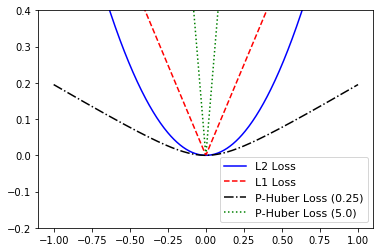

In [62]:
#Draw the picture for above 4 regression loss function
x_array = sess.run(x_vals)
plt.plot(x_array, l2_y_out, 'b-', label = 'L2 Loss')
plt.plot(x_array, l1_y_out, 'r--', label = 'L1 Loss')
plt.plot(x_array, phuber1_y_out, 'k-.', label = 'P-Huber Loss (0.25)')
plt.plot(x_array, phuber2_y_out, 'g:', label = 'P-Huber Loss (5.0)')
plt.ylim(-0.2, 0.4)
plt.legend(loc= 'lower right', prop={'size': 11})
plt.show()

【问题】：Pseudo Huber loss function最好找个文章或者论文来看一下

### Classification Loss Function

In [71]:
x_vals = tf.linspace(-3.,5.,500)
target = tf.constant(1.)
targets = tf.fill([500,], 1.)

In [72]:
#Hinge loss function
#常用于SVM，当然DP里面也能用就是了
#数学表示： max(0.,+-1 - target * y)
#直观来看：不关心已经判断正确的数据，只计算判断错误的数据的loss
hinge_y_vals = tf.maximum(0., 1. - tf.multiply(target, x_vals))
hinge_y_out = sess.run(hinge_y_vals)

In [73]:
#Classification中最重要的loss function之一
#Cross-entropy loss／logistic loss function
#用于binary classification
xentropy_y_vals = - tf.multiply(target, 
                                tf.log(x_vals))- tf.multiply(1. - target,
                                                            tf.log(1. - x_vals))
xentropy_y_out = sess.run(xentropy_y_vals)

In [76]:
#Sigmoid cross entropy loss function
#transform the x_values by sigmoid before cross entropy loss function
xentropy_sigmoid_y_vals = tf.nn.sigmoid_cross_entropy_with_logits(logits = x_vals, labels = targets)
xentropy_sigmoid_y_out = sess.run(xentropy_sigmoid_y_vals)

In [77]:
#Weighted Loss entropy loss function
weight = tf.constant(0.5)
xentropy_weighted_y_vals = tf.nn.weighted_cross_entropy_with_logits(x_vals,
                                                                   targets,
                                                                   weight)
xentropy_weighted_y_out = sess.run(xentropy_weighted_y_vals)

P.38~P.40

# Back Propagation

initialize_all_variables()已经失效，现在用的是global_variable_initializer

In [122]:
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10.,100)
x_data = tf.placeholder(tf.float32,shape=[1])
y_target = tf.placeholder(tf.float32,shape=[1])
#下面初始化A使用的是比较常见的初始化方法：random_variable
A = tf.Variable(tf.random_normal(shape=[1]))

In [123]:
my_output = tf.multiply(x_data, A)

In [124]:
loss = tf.square(my_output - y_target)

In [125]:
init = tf.global_variables_initializer()
sess.run(init)

In [126]:
my_opt = tf.train.GradientDescentOptimizer(learning_rate=0.02)
train_step = my_opt.minimize(loss)

In [127]:
#np.random.choice是一个很好的用来生成random index的方法
for i in range(100):
    rand_index = np.random.choice(100)
    rand_x = [x_vals[rand_index]]
    rand_y = [y_vals[rand_index]]
    sess.run(train_step, feed_dict={x_data:rand_x,y_target:rand_y})
    if (i+1)%25 == 0:
        print("Step #" + str(i+1) + " A = " + str(sess.run(A)))
        print("Loss = " + str(sess.run(loss, 
                                       feed_dict={x_data:rand_x,y_target:rand_y})))
        

Step #25 A = [ 6.18958759]
Loss = [ 6.2951808]
Step #50 A = [ 8.46996117]
Loss = [ 0.23582634]
Step #75 A = [ 9.45027733]
Loss = [ 2.85112381]
Step #100 A = [ 9.57971859]
Loss = [ 1.46219897]


【问题】：tensorflow.python.framework.ops

【问题】：.reset_default_graph()

In [153]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()

In [154]:
#np.concatenate((a1,a2,...),axis = 0) axis=0是指的纵轴
x_vals = np.concatenate((np.random.normal(-1,1,50), np.random.normal(3,1,50)))
y_vals = np.concatenate((np.repeat(0.,50), np.repeat(1.,50)))
x_data = tf.placeholder(tf.float32,shape = [1])
y_target = tf.placeholder(tf.float32,shape= [1])
A = tf.Variable(tf.random_normal(mean=10, shape=[1]))

In [155]:
my_output = tf.add(x_data, A)

In [156]:
#tf.expand_dims()
my_output_expanded = tf.expand_dims(my_output, 0)
y_target_expanded = tf.expand_dims(y_target, 0)

In [157]:
init = tf.global_variables_initializer()
sess.run(init)

In [158]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = my_output_expanded,
                                                  labels = y_target_expanded)

In [159]:
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

In [160]:
for i in range(1400):
    rand_index = np.random.choice(100)
    rand_x = [x_vals[rand_index]]
    rand_y = [y_vals[rand_index]]
    
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%200 == 0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(xentropy, 
                                       feed_dict={x_data:rand_x,
                                                 y_target:rand_y})))

Step #200 A = [ 5.16828871]
Loss = [[ 0.00027306]]
Step #400 A = [ 1.14451063]
Loss = [[ 0.00916713]]
Step #600 A = [-0.40367213]
Loss = [[ 0.03889571]]
Step #800 A = [-1.12536645]
Loss = [[ 0.03341172]]
Step #1000 A = [-1.1559335]
Loss = [[ 0.31781512]]
Step #1200 A = [-1.13508964]
Loss = [[ 0.45462969]]
Step #1400 A = [-1.12788677]
Loss = [[ 0.04701942]]
